
# UFC Style Analysis — Notebook (Auto-Detect Excel + UAM vs Weighted)

This notebook analyzes **UFC fighting styles**: representation, win ratios, champion conversion rates, and cross-source comparisons (your data vs ESPN).  
It **auto-detects your Excel file** and includes **Unweighted Arithmetic Mean (UAM)** vs **Weighted Average** for win ratios.


In [116]:

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


In [117]:

# Auto-detect the UFC Excel file in common locations or anywhere in the repo
candidates = [
    "../data/UFC Fighters (3_2022).xlsx"
]

EXCEL_PATH = None
for c in candidates:
    if os.path.exists(c):
        EXCEL_PATH = c
        break

if EXCEL_PATH is None:
    matches = glob.glob("**data/UFC Fighters (3_2022)*.xlsx", recursive=True)
    if matches:
        EXCEL_PATH = matches[0]

if EXCEL_PATH is None:
    raise FileNotFoundError("Could not find the UFC Fighters Excel file. Please add it to the repo or update the search patterns.")

print("Using Excel file:", EXCEL_PATH)


Using Excel file: ../data/UFC Fighters (3_2022).xlsx


In [118]:

def a1_to_ix(a1: str):
    import re
    m = re.match(r"^\s*([A-Za-z]+)(\d+)\s*$", a1)
    if not m: raise ValueError(f'Bad A1 address: {a1}')
    col_s, row_s = m.groups()
    col = 0
    for ch in col_s.upper():
        col = col*26 + (ord(ch)-64)
    return int(row_s)-1, col-1

def parse_range(df: pd.DataFrame, rng: str):
    a, b = [x.strip() for x in rng.split(':')]
    r1,c1 = a1_to_ix(a)
    r2,c2 = a1_to_ix(b)
    return df.iloc[min(r1,r2):max(r1,r2)+1, min(c1,c2):max(c1,c2)+1]

def to_num(x):
    return pd.to_numeric(pd.Series(x).astype(str).str.replace('%','', regex=False), errors='coerce')

def exclude_summary(labels):
    lab = pd.Series(labels).astype(str).str.lower()
    return ~lab.str.contains(r"\b(?:avg|average|overall|total|mean)\b", regex=True)


In [119]:

xls = pd.ExcelFile(EXCEL_PATH)
xls.sheet_names


['Fighters from 11-1993 to 3-2022', 'Cross Source Analysis']

In [120]:

base = pd.read_excel(EXCEL_PATH, sheet_name=0, header=None)


## 1) Style Representation

In [121]:

names_rep = parse_range(base, 'C1:L1').values.flatten().tolist()
vals_rep  = parse_range(base, 'C2:L2').values.flatten().tolist()
rep_df = pd.DataFrame({'Style': names_rep, 'Representation_raw': to_num(vals_rep)}).dropna(subset=['Style'])
rep_df


,Style,Representation_raw
0,Wrestling,420
1,BJJ,183
2,Judo,65
3,Freestyle,477
4,Muay Thai,55
5,Karate,67
6,Kickboxing,73
7,Boxing,48
8,TKD,38
9,Kung Fu,15


In [122]:

rep_raw = rep_df['Representation_raw']
if rep_raw.max() > 1.0 and rep_raw.max() <= 100.0:
    rep_df['Representation_pct'] = rep_raw
    rep_note = '(interpreted as %)'
elif rep_raw.max() <= 1.0:
    rep_df['Representation_pct'] = rep_raw * 100.0
    rep_note = '(converted from proportion)'
else:
    total = rep_raw.sum()
    rep_df['Representation_pct'] = (rep_raw / total) * 100.0 if total else rep_raw
    rep_note = '(normalized to % of total)'
rep_note, rep_df[['Style','Representation_pct']].sort_values('Representation_pct', ascending=False).head()


('(normalized to % of total)',
         Style  Representation_pct
 3   Freestyle           33.102012
 0   Wrestling           29.146426
 1         BJJ           12.699514
 6  Kickboxing            5.065926
 5      Karate            4.649549)

<Figure size 640x480 with 0 Axes>

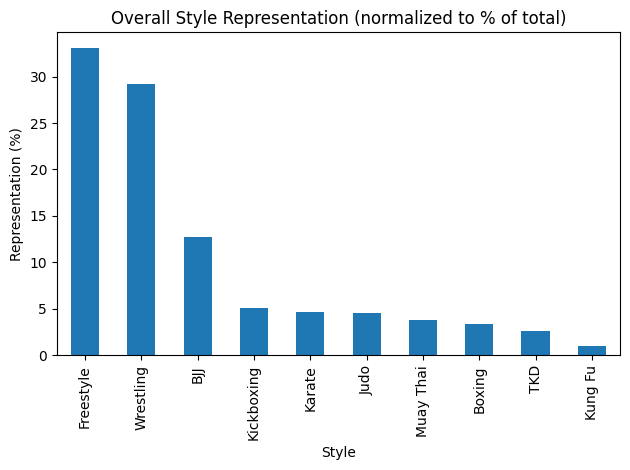

In [123]:

plt.figure()
rep_df.sort_values('Representation_pct', ascending=False).plot(
    x='Style', y='Representation_pct', kind='bar', legend=False
)
plt.ylabel('Representation (%)')
plt.title(f'Overall Style Representation {rep_note}')
plt.tight_layout()
plt.show()


## 2) Win Ratios by Style — **UAM vs Weighted**

In [124]:

# Win ratios: B1:L1 (style names), B6:L6 (values)
names_win = parse_range(base, 'B1:L1').values.flatten().tolist()
vals_win  = parse_range(base, 'B6:L6').values.flatten().tolist()
win_df = pd.DataFrame({'Style': names_win, 'Win_Ratio': to_num(vals_win)}).dropna(subset=['Style'])

# Fighter counts for weights (reuse styles from C1:L1 and counts from C2:L2)
fighters = parse_range(base, 'C2:L2').values.flatten().tolist()
fighters_df = pd.DataFrame({'Style': names_rep, 'Fighters': to_num(fighters)})

# Merge and exclude summary labels if any
win_w = win_df.merge(fighters_df, on='Style', how='left')
mask = exclude_summary(win_w['Style'])

# Compute UAM and Weighted Average
uam = win_w.loc[mask, 'Win_Ratio'].mean()
if win_w.loc[mask, 'Fighters'].fillna(0).sum() > 0:
    wavg = np.average(win_w.loc[mask, 'Win_Ratio'], weights=win_w.loc[mask, 'Fighters'].fillna(0))
else:
    wavg = np.nan

avg_comparison = pd.DataFrame({
    'Metric': ['UAM (Unweighted Arithmetic Mean)', 'Weighted Average (by Fighters)'],
    'Win Ratio': [uam, wavg]
})
avg_comparison


,Metric,Win Ratio
0,UAM (Unweighted Arithmetic Mean),1.285946
1,Weighted Average (by Fighters),1.242443


<Figure size 640x480 with 0 Axes>

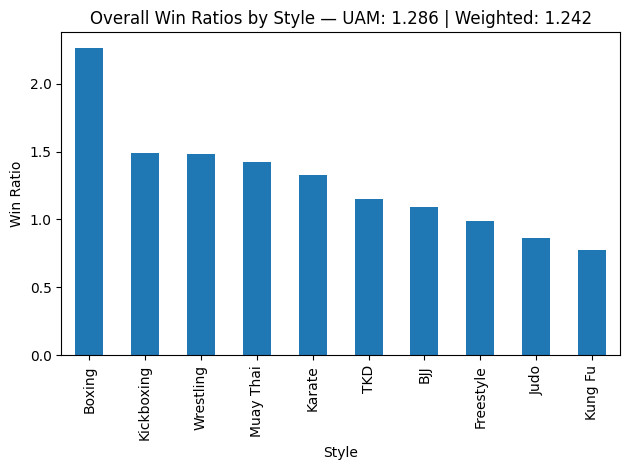

In [125]:

plt.figure()
win_w.loc[mask].sort_values('Win_Ratio', ascending=False).plot(
    x='Style', y='Win_Ratio', kind='bar', legend=False
)
plt.ylabel('Win Ratio')
plt.title(f'Overall Win Ratios by Style — UAM: {uam:.3f} | Weighted: {wavg:.3f}')
plt.tight_layout()
plt.show()



> **Why they differ:** UAM gives each style equal weight regardless of size.  
> Weighted average gives each style weight proportional to its **number of fighters**. If one style dominates headcount, it will pull the weighted average toward its own ratio.


## 3) Champion Conversion Rate by Style — Cross Source Analysis

In [126]:

cross_name = next((nm for nm in xls.sheet_names if 'cross' in nm.lower()), None)
assert cross_name is not None, "Cross Source Analysis sheet not found. Please rename accordingly."

cross = pd.read_excel(EXCEL_PATH, sheet_name=cross_name, header=None)

styles_conv = parse_range(cross, 'A3:A13').values.flatten().tolist()
observed_conv  = to_num(parse_range(cross, 'D3:D13').values.flatten().tolist())
espn_conv   = to_num(parse_range(cross, 'E3:E13').values.flatten().tolist())

conv_df = pd.DataFrame({
    'Style': styles_conv,
    'Conversion Raw (Observed)': observed_conv,
    'Conversion Raw (ESPN)': espn_conv
}).dropna(subset=['Style'])

# Percent versions
conv_pct = conv_df.copy()
if conv_pct[['Conversion Raw (Observed)','Conversion Raw (ESPN)']].max().max() <= 1.0:
    conv_pct['Conversion % (Observed)'] = conv_pct['Conversion Raw (Observed)'] * 100.0
    conv_pct['Conversion % (ESPN)']  = conv_pct['Conversion Raw (ESPN)'] * 100.0
    conv_note = '(converted from proportion)'
else:
    conv_pct['Conversion % (Observed)'] = conv_pct['Conversion Raw (Observed)']
    conv_pct['Conversion % (ESPN)']  = conv_pct['Conversion Raw (ESPN)']
    conv_note = '(interpreted as %)'
mask_c = exclude_summary(conv_pct['Style'])
avg_y = conv_pct.loc[mask_c, 'Conversion % (Observed)'].mean()
avg_e = conv_pct.loc[mask_c, 'Conversion % (ESPN)'].mean()

conv_pct[['Style','Conversion % (Observed)','Conversion % (ESPN)']].head()


,Style,Conversion % (Observed),Conversion % (ESPN)
0,Total,5.34,4.86
1,Wrestling,9.05,6.67
2,BJJ,6.01,9.29
3,Judo,1.54,0.00
4,Freestyle,0.21,0.00


<Figure size 640x480 with 0 Axes>

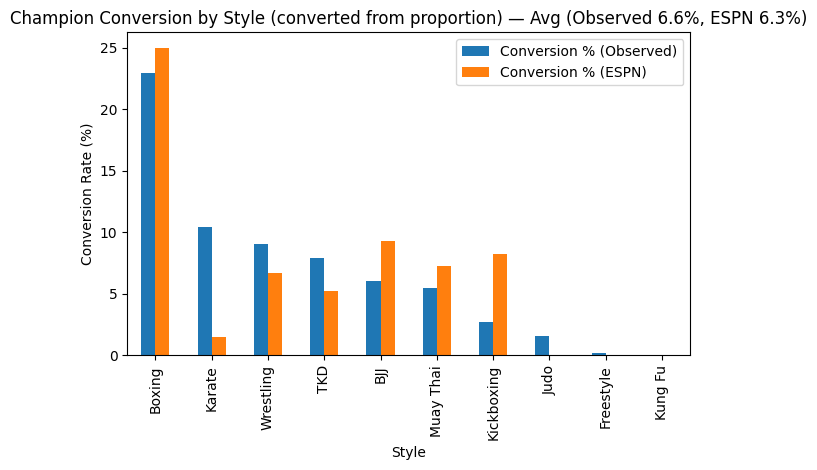

In [127]:

plt.figure()
plot_df = conv_pct.loc[mask_c].set_index('Style')[['Conversion % (Observed)','Conversion % (ESPN)']].sort_values('Conversion % (Observed)', ascending=False)
plot_df.plot(kind='bar')
plt.ylabel('Conversion Rate (%)')
plt.title(f'Champion Conversion by Style {conv_note} — Avg (Observed {avg_y:.1f}%, ESPN {avg_e:.1f}%)')
plt.tight_layout()
plt.show()


## 4) Champion Representation by Style — Cross Source Analysis

In [128]:

styles_rep2 = parse_range(cross, 'A2:A13').values.flatten().tolist()
observed_rep2  = to_num(parse_range(cross, 'B3:B13').values.flatten().tolist())
espn_rep2   = to_num(parse_range(cross, 'C3:C13').values.flatten().tolist())

def pad(lst, n):
    out = list(lst)
    while len(out) < n: out.append(np.nan)
    return out

mx = max(len(styles_rep2), len(observed_rep2), len(espn_rep2))
styles_rep2 = pad(styles_rep2, mx)
observed_rep2  = pad(observed_rep2, mx)
espn_rep2   = pad(espn_rep2, mx)

rep2_df = pd.DataFrame({
    'Style': styles_rep2,
    'Champions (Observed)': observed_rep2,
    'Champions (ESPN)': espn_rep2
}).dropna(subset=['Style'])

rep2_df.head()


,Style,Champions (Observed),Champions (ESPN)
0,Style,77.0,70.0
1,Total,38.0,28.0
2,Wrestling,11.0,17.0
3,BJJ,1.0,0.0
4,Judo,1.0,0.0


<Figure size 640x480 with 0 Axes>

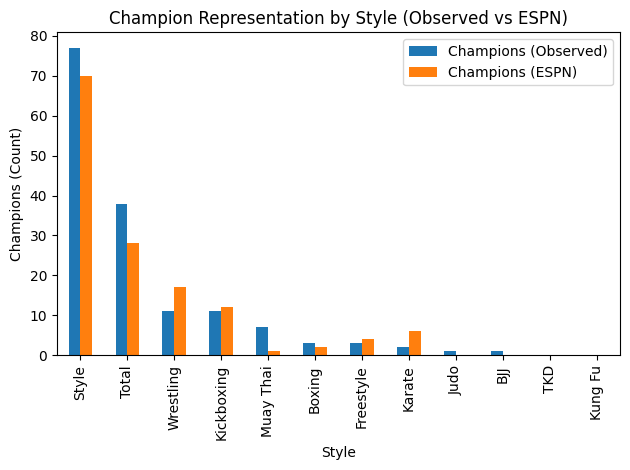

In [129]:

plt.figure()
rep2_plot = rep2_df.set_index('Style')[['Champions (Observed)','Champions (ESPN)']].sort_values('Champions (Observed)', ascending=False)
rep2_plot.plot(kind='bar')
plt.ylabel('Champions (Count)')
plt.title('Champion Representation by Style (Observed vs ESPN)')
plt.tight_layout()
plt.show()



## Insights
## 1. Style Representation (Roster Size)

Freestyle Wrestling & Wrestling combined → by far the largest contributor of fighters (≈ 29–33%).

BJJ → ~12%.

Striking arts like Muay Thai, Boxing, Karate, Kickboxing each only ~3–5%.

Niche arts (Judo, TKD, Kung Fu, Sambo) contribute tiny fractions.

Grappling-heavy bases dominate the UFC talent pool.

## 2. Champion Conversion Rates (Observed vs ESPN)

From the Cross Source Analysis:

Wrestling: ~9.0% conversion (Observed) vs ~6.7% (ESPN).

BJJ: ~6.0% vs ~9.3%.

Boxing: ~22.9% (!) in Observed vs 25% ESPN → very high efficiency relative to its small representation.

Muay Thai: moderate ~5–7%.

Karate: ~10% Observed → notable outlier given small base.

Judo, TKD, Kung Fu: near zero or extremely low.

Key insight: Wrestling supplies the most champions by volume, but striking specializations like Boxing and Karate convert to champions at a higher per-capita rate.

## 3. Championship Enrichment

Wrestling: +20% enrichment → not just numerous, but disproportionately successful.

Boxing: +11% enrichment → far exceeds its tiny pool.

BJJ: slight enrichment, but less dominant than people often claim.

Karate & Kickboxing: mixed; Karate surprisingly positive.

Muay Thai, TKD, Judo: mostly neutral to negative.

- Enrichment shows where a style “punches above its weight”: Wrestling + Boxing lead.

## 4. Cross-Source Agreement (Observed vs ESPN)

Broad agreement on the top two pipelines (Wrestling & BJJ).

ESPN weights BJJ champions slightly more heavily than your dataset.

Minor differences in smaller categories are often due to classification variance (e.g., does ESPN call a fighter “Kickboxing” or “Karate”?).

- Different taxonomies shift the numbers, but the overall narrative is consistent: grappling is the backbone, with select striking arts producing high-efficiency champions.

## Conclusions
- Wrestling is the backbone of UFC success. It supplies the largest share of fighters and converts them into champions at rates above expectation, showing both depth and efficiency.

- Boxing is the per-capita standout. Despite a small pool of fighters, its conversion rate into champions is among the highest while also boasting the highest win ratio by far, suggesting technical striking translates exceptionally well at both the contender and  elite level.

- BJJ remains a strong pipeline but less dominant than the popular narrative. Its representation is solid, but enrichment is weaker compared to Wrestling and Boxing.

## Caveats & Next Steps

- Weight classes matter. Styles may succeed differently in lighter vs heavier divisions (e.g., Wrestling dominance in lighter weights, Boxing in heavier).

- Time splits. Style prevalence and success have shifted over decades — early UFCs vs the modern era look very different.

- Opponent quality. Raw win ratios and conversion rates don’t adjust for strength of schedule; future work could weight results by opponent ranking.
